In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn ofrece una variedad de modelos Naive Bayes. Para este problema, utilizamos MultinomialNB, que es adecuado para datos de conteo como este.
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

# TP3: Detector de SPAM

Uno de los problemas más comunes en clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo (Naive Bayes). La detección de SPAM sigue siendo un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para evadir los filtros de correo no deseado.

Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado técnicas más avanzadas, como algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico utilizaremos un conjunto de datos que contiene 4601 observaciones de correos electrónicos, de los cuales 2788 son legítimos y 1813 son SPAM. Como el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo. En este caso, el dataset ya ha sido preprocesado utilizando técnicas típicas de Procesamiento de Lenguaje Natural (NLP), como el conteo de la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural desempeña un rol fundamental en la detección de SPAM, ya que permite analizar el contenido textual y extraer características relevantes para la clasificación. Además del simple conteo de palabras, se pueden aplicar técnicas más sofisticadas, como la extracción de características semánticas o el análisis de sentimientos, para mejorar la precisión de los modelos.

En este dataset, se cuenta la cantidad de ocurrencias de cada palabra en los distintos correos:

![spam counter](../img/spam.png)

Para preservar la privacidad de los mensajes, las frecuencias han sido normalizadas. El dataset está compuesto por 54 columnas de atributos denominadas:

- `word_freq_XXXX`: donde `XXXX` representa una palabra o símbolo. Los valores son enteros que van de 0 a 20.000.

Adicionalmente, hay una columna llamada `spam`, que toma el valor 1 si el correo es SPAM, y 0 si es legítimo.

Los clasificadores de Bayes ingenuos fueron de los primeros filtros utilizados por aplicaciones de correo electrónico, y se basan en este principio: partiendo de una probabilidad a priori de que un correo sea SPAM, ciertas palabras pueden modificar esa probabilidad a posteriori, indicando con mayor o menor certeza si un mensaje es o no SPAM.

### Carga del dataset

In [49]:
dataset = pd.read_csv("../datasets/spambase.csv") # Cargamos los datos desde un archivo CSV

# Validación básica
assert "spam" in dataset.columns, "Target column 'spam' not found."

dataset.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
5,0,0,0,0,1850,0,0,1850,0,0,...,0,0,0,0,223,0,0,0,0,1
6,0,0,0,0,1920,0,0,0,0,640,...,0,0,0,0,54,0,164,54,0,1
7,0,0,0,0,1880,0,0,1880,0,0,...,0,0,0,0,206,0,0,0,0,1
8,150,0,460,0,610,0,300,0,920,760,...,0,0,0,0,271,0,181,203,22,1
9,60,120,770,0,190,320,380,0,60,0,...,0,0,0,40,30,0,244,81,0,1


In [50]:
dataset["spam"].value_counts()

spam
0    2788
1    1813
Name: count, dtype: int64

### Análisis exploratorio

Para obtener las palabras más frecuentes según si el correo es SPAM o no, podemos agrupar por clase con `groupby`::

In [51]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()

10 palabras o símbolos más frecuentes en correos SPAM

In [52]:
top10_spam_df = column_sum.loc[1].sort_values(ascending=False).head(10).reset_index()
top10_spam_df.columns = ["feature", "total_frequency_in_spam"]
top10_spam_df

,feature,total_frequency_in_spam
0,word_freq_you,4105599
1,word_freq_your,2502597
2,word_freq_will,997100
3,word_freq_free,939790
4,word_freq_our,931799
5,char_freq_!,931352
6,word_freq_all,732080
7,word_freq_mail,635470
8,word_freq_email,578759
9,word_freq_business,521250


10 palabras o símbolos más frecuentes en correos NO SPAM (ham)

In [53]:
top10_ham_df = column_sum.loc[0].sort_values(ascending=False).head(10).reset_index()
top10_ham_df.columns = ["feature", "total_frequency_in_ham"]
top10_ham_df

,feature,total_frequency_in_ham
0,word_freq_you,3541702
1,word_freq_george,3527559
2,word_freq_hp,2496576
3,word_freq_will,1495268
4,word_freq_your,1223098
5,word_freq_hpl,1204398
6,word_freq_re,1159138
7,word_freq_edu,800669
8,word_freq_address,681569
9,word_freq_meeting,604460


Palabras/símbolos en común

In [54]:
pd.merge(top10_spam_df, top10_ham_df, on='feature', how='inner')

,feature,total_frequency_in_spam,total_frequency_in_ham
0,word_freq_you,4105599,3541702
1,word_freq_your,2502597,1223098
2,word_freq_will,997100,1495268


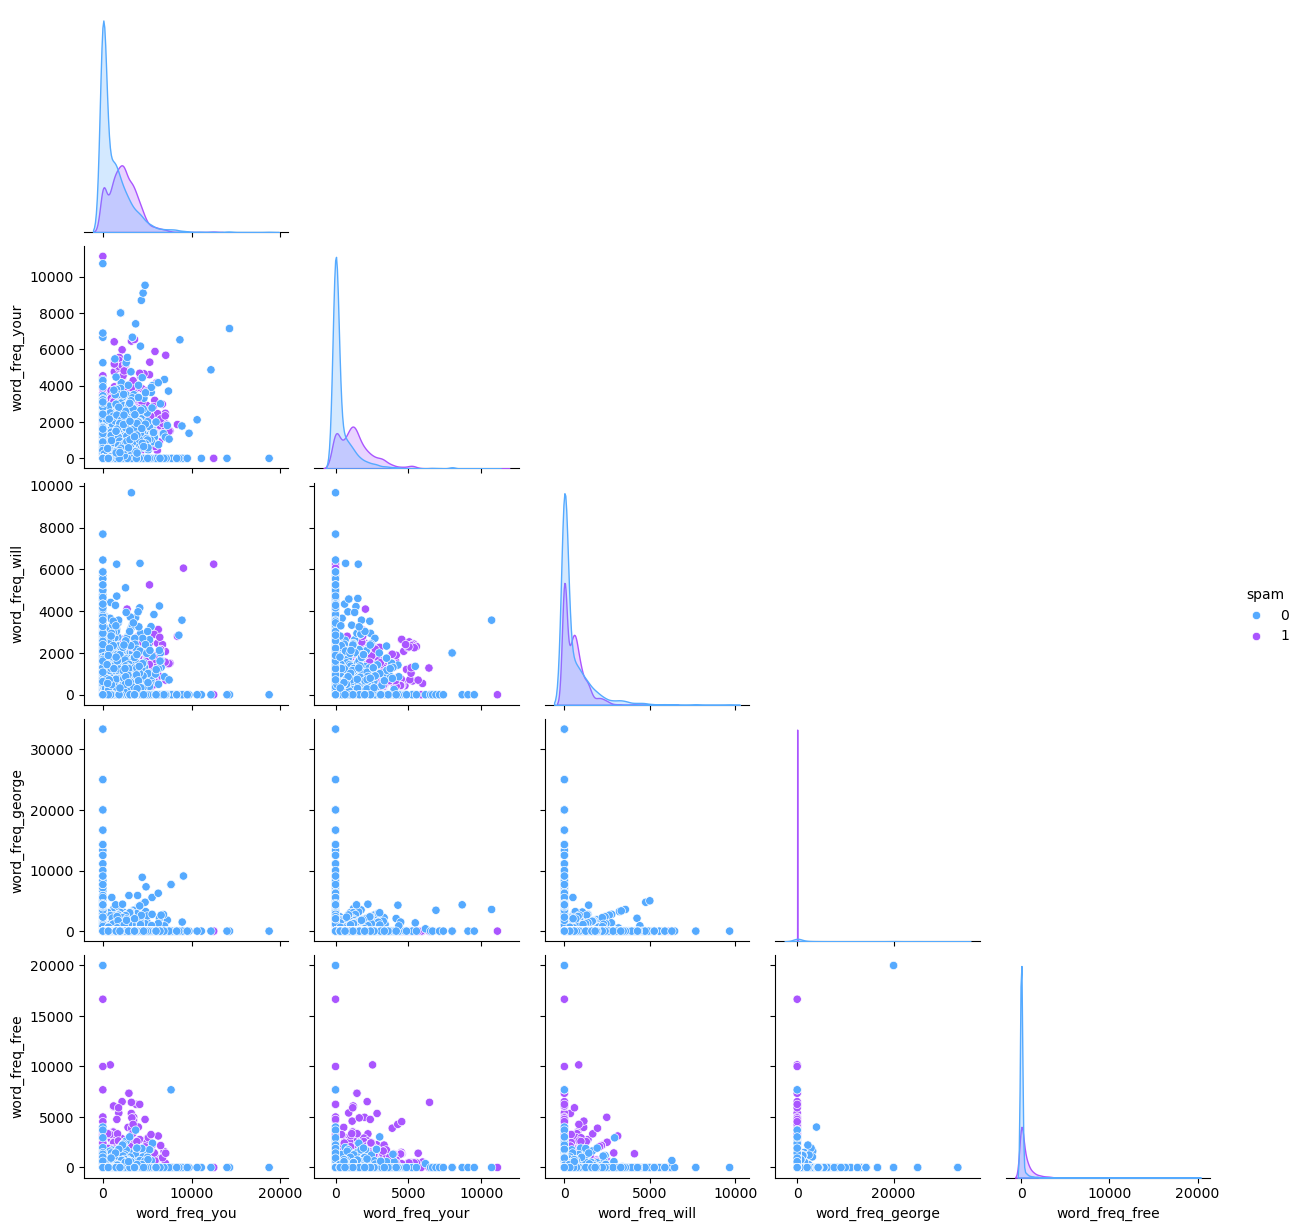

In [55]:
col_sel = ["word_freq_you", "word_freq_your", "word_freq_will", "word_freq_george", "word_freq_free", "spam"]
dataset_visualization = dataset[col_sel]

sns.pairplot(data=dataset_visualization, diag_kind="kde", hue="spam", palette="cool", corner=True);

### Preparación de los datos

Obtenemos los atributos y el target:

In [56]:
X = dataset.drop(columns="spam")
y = dataset["spam"]

### División del dataset en entrenamiento y evaluación

In [57]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

### --- Naive Bayes (Multinomial) ---
Entrenamos un clasificador de Bayes ingenuo multinomial (adecuado para conteos/frecuencias)

In [58]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [59]:
# Predicciones y probabilidades
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]

### --- Logistic Regression (with normalization) ---
Usamos un Pipeline con MinMaxScaler para normalizar y LogisticRegression para clasificar

In [60]:
lr_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("lr", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ]
)
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=1000))])

In [61]:
# Predicciones y probabilidades
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

In [62]:
def sens_spec(cm):
    sensitivity = cm[1, 1] / np.sum(cm[1, :])
    specifity = cm[0, 0] / np.sum(cm[0, :])
    balanced_accuracy = (sensitivity + specifity) / 2

    return sensitivity, specifity, balanced_accuracy

### --- Naive Bayes Multinomial (with normalization) ---

In [63]:
nb_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("lr", MultinomialNB())
    ]
)
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('lr', MultinomialNB())])

In [64]:
# Predicciones y probabilidades
y_pred_nb_norm = nb_pipeline.predict(X_test)
y_proba_nb_norm = nb_pipeline.predict_proba(X_test)[:, 1]

### --- Confusion matrices ---

In [65]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
sensitivity_nb, specifity_nb, balanced_accuracy_nb = sens_spec(cm_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
sensitivity_lr, specifity_lr, balanced_accuracy_lr = sens_spec(cm_lr)
cm_nb_norm = confusion_matrix(y_test, y_pred_nb_norm)
sensitivity_nb_norm, specifity_nb_norm, balanced_accuracy_nb_norm = sens_spec(cm_nb_norm)

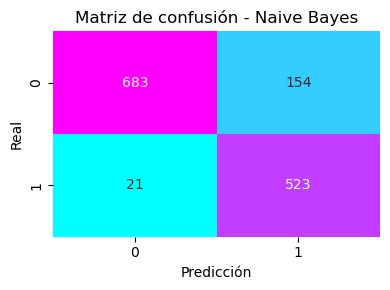

In [66]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="cool", cbar=False)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Naive Bayes")

plt.tight_layout()
plt.show()

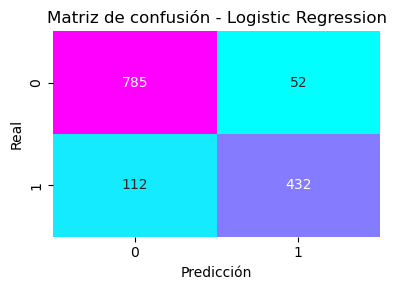

In [67]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="cool", cbar=False)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Logistic Regression")

plt.tight_layout()
plt.show()

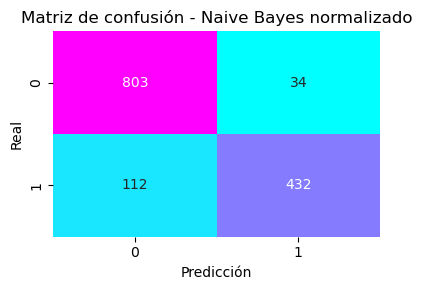

In [68]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm_nb_norm, annot=True, fmt="d", cmap="cool", cbar=False)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Naive Bayes normalizado")

plt.tight_layout()
plt.show()

### Cálculo de las métricas

In [69]:
print("Naive Bayes:")
print(f"Sensibilidad: {sensitivity_nb}")
print(f"Especificidad: {specifity_nb}")
print(f"Exactitud balanceada: {balanced_accuracy_nb}")
print("\nPrecision/Recall:")
target_names = ["SPAM", "NO SPAM"]
print(classification_report(y_test, y_pred_nb, target_names=target_names))
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
print(f"Naive Bayes -> precision={precision_nb:.4f}, recall={recall_nb:.4f}")

Naive Bayes:
Sensibilidad: 0.9613970588235294
Especificidad: 0.8160095579450418
Exactitud balanceada: 0.8887033083842857

Precision/Recall:
              precision    recall  f1-score   support

        SPAM       0.97      0.82      0.89       837
     NO SPAM       0.77      0.96      0.86       544

    accuracy                           0.87      1381
   macro avg       0.87      0.89      0.87      1381
weighted avg       0.89      0.87      0.87      1381

Naive Bayes -> precision=0.7725, recall=0.9614


In [70]:
print("Logistic Regression:")
print(f"Sensibilidad: {sensitivity_lr}")
print(f"Especificidad: {specifity_lr}")
print(f"Exactitud balanceada: {balanced_accuracy_lr}")
print("\nPrecision/Recall:")
target_names = ["SPAM", "NO SPAM"]
print(classification_report(y_test, y_pred_lr, target_names=target_names))
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
print(f"Logistic Regression -> precision={precision_lr:.4f}, recall={recall_lr:.4f}")

Logistic Regression:
Sensibilidad: 0.7941176470588235
Especificidad: 0.937873357228196
Exactitud balanceada: 0.8659955021435097

Precision/Recall:
              precision    recall  f1-score   support

        SPAM       0.88      0.94      0.91       837
     NO SPAM       0.89      0.79      0.84       544

    accuracy                           0.88      1381
   macro avg       0.88      0.87      0.87      1381
weighted avg       0.88      0.88      0.88      1381

Logistic Regression -> precision=0.8926, recall=0.7941


In [71]:
print("Naive Bayes normalizado:")
print(f"Sensibilidad: {sensitivity_nb_norm}")
print(f"Especificidad: {specifity_nb_norm}")
print(f"Exactitud balanceada: {balanced_accuracy_nb_norm}")
print("\nPrecision/Recall:")
target_names = ["SPAM", "NO SPAM"]
print(classification_report(y_test, y_pred_nb_norm, target_names=target_names))
precision_nb_norm = precision_score(y_test, y_pred_nb_norm)
recall_nb_norm = recall_score(y_test, y_pred_nb_norm)
print(f"Logistic Regression -> precision={precision_nb_norm:.4f}, recall={recall_nb_norm:.4f}")

Naive Bayes normalizado:
Sensibilidad: 0.7941176470588235
Especificidad: 0.959378733572282
Exactitud balanceada: 0.8767481903155527

Precision/Recall:
              precision    recall  f1-score   support

        SPAM       0.88      0.96      0.92       837
     NO SPAM       0.93      0.79      0.86       544

    accuracy                           0.89      1381
   macro avg       0.90      0.88      0.89      1381
weighted avg       0.90      0.89      0.89      1381

Logistic Regression -> precision=0.9270, recall=0.7941


### --- Precision-Recall curves ---

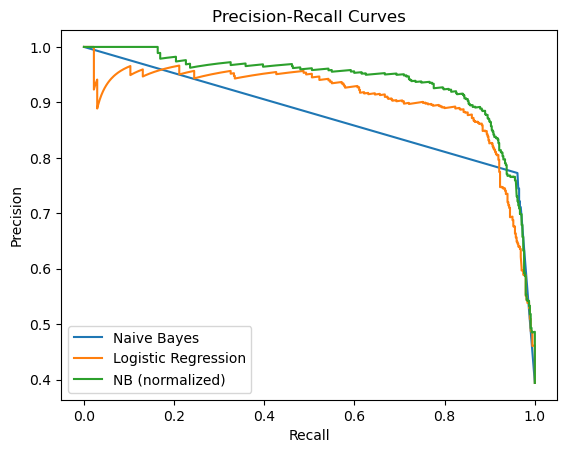

In [72]:
prec_nb, rec_nb, thr_nb = precision_recall_curve(y_test, y_proba_nb)
prec_lr, rec_lr, thr_lr = precision_recall_curve(y_test, y_proba_lr)
prec_nb_norm, rec_nb_norm, thr_nb_norm = precision_recall_curve(y_test, y_proba_nb_norm)

plt.figure()
plt.plot(rec_nb, prec_nb, label="Naive Bayes")
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_nb_norm, prec_nb_norm, label="NB (normalized)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="best")
plt.show()

### --- ROC y AUC ---

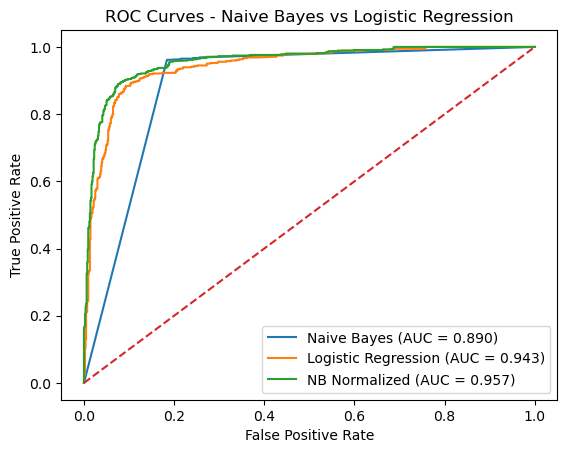


AUCs -> Naive Bayes: 0.8903, Logistic Regression: 0.9429, NB Normalized: 0.9570


In [73]:
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_nb_norm, tpr_nb_norm, _ = roc_curve(y_test, y_proba_nb_norm)

auc_nb = roc_auc_score(y_test, y_proba_nb)
auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_nb_norm = roc_auc_score(y_test, y_proba_nb_norm)

plt.figure()
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_nb_norm, tpr_nb_norm, label=f"NB Normalized (AUC = {auc_nb_norm:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Naive Bayes vs Logistic Regression")
plt.legend(loc="lower right")
plt.show()

print(f"\nAUCs -> Naive Bayes: {auc_nb:.4f}, Logistic Regression: {auc_lr:.4f}, NB Normalized: {auc_nb_norm:.4f}")